# Prophet

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import itertools

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import seaborn as sns

np.random.seed(2530)

In [2]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

In [3]:
## para guardar modelos
import os
from pathlib import Path
project_path = Path(os.getcwd()).parent
import pickle
import joblib  

In [4]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [13]:
train_data_prophet = pd.read_parquet('../data/03_train-test/train_data_prophet.parquet')
test_data_prophet = pd.read_parquet('../data/03_train-test/test_data_prophet.parquet')
all_data_prophet = pd.read_parquet('../data/03_train-test/all_data_prophet.parquet')

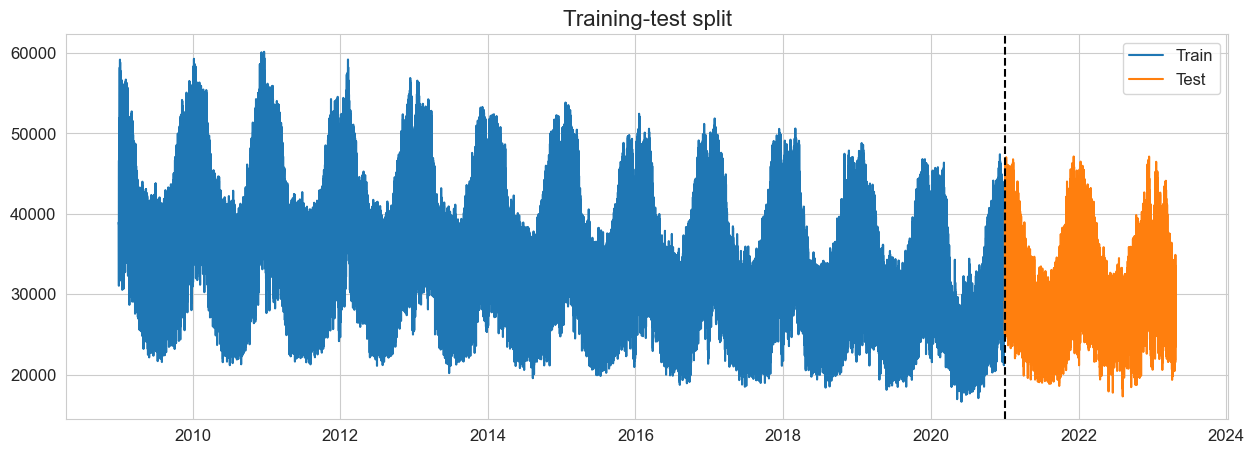

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(train_data_prophet['ds'], train_data_prophet['y'],  label="Train")
plt.plot(test_data_prophet['ds'], test_data_prophet['y'],  label="Test")
plt.axvline(datetime.date(2021,1,1), color="black", ls="--")
ax.set_title("Training-test split")
plt.legend();

In [7]:
prophet_model = Prophet()

In [8]:
%%time
prophet_model.fit(train_data_prophet)

Wall time: 19min 21s


In [9]:
# save the model
joblib.dump(prophet_model, project_path.joinpath('data/models/prophet.pkl'))

['C:\\Users\\mpena\\OneDrive\\Escritorio\\TFG\\PYTHON\\data\\models\\prophet.pkl']

In [10]:
# load the model
prophet_model = joblib.load(project_path.joinpath('data/models/prophet.pkl')) # Carga del modelo.

In [11]:
%%time
prophet_predict_df = prophet_model.predict(test_data_prophet)
prophet_predict_df.head()

Wall time: 15.4 s


ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2021-01-01 00:00:00  28118.036479  23057.302195  29682.951449  28118.036479   
1 2021-01-01 00:30:00  28117.967210  22536.537420  29166.694363  28117.967210   
2 2021-01-01 01:00:00  28117.897941  22302.912873  28970.862054  28117.897941   
3 2021-01-01 01:30:00  28117.828672  21777.869194  28399.912029  28117.828672   
4 2021-01-01 02:00:00  28117.759403  21645.655761  28373.751631  28117.759403   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  28118.036479    -1714.026218          -1714.026218          -1714.026218   
1  28117.967210    -2215.649565          -2215.649565          -2215.649565   
2  28117.897941    -2595.658649          -2595.658649          -2595.658649   
3  28117.828672    -2935.690628          -2935.690628          -2935.690628   
4  28117.759403    -3291.399058          -3291.399058          -3291.399058   

         daily  ...       weekly  weekly_lower  weekly_upper       yearly  \
0 -5486.336077  ...  1450.697166   1450.697166   1450.697166  2321.612693   
1 -5978.690844  ...  1438.651263   1438.651263   1438.651263  2324.390016   
2 -6348.728657  ...  1425.886754   1425.886754   1425.886754  2327.183253   
3 -6678.040543  ...  1412.357534   1412.357534   1412.357534  2329.992381   
4 -7022.232926  ...  1398.016495   1398.016495   1398.016495  2332.817373   

   yearly_lower  yearly_upper  multiplicative_terms  \
0   2321.612693   2321.612693                   0.0   
1   2324.390016   2324.390016                   0.0   
2   2327.183253   2327.183253                   0.0   
3   2329.992381   2329.992381                   0.0   
4   2332.817373   2332.817373                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  26404.010261  
1                         0.0                         0.0  25902.317645  
2                         0.0                         0.0  25522.239292  
3                         0.0                         0.0  25182.138044  
4                         0.0                         0.0  24826.360345  

[5 rows x 22 columns]

Prophet also includes a function that allows us to easily visualise the prediction component (trends and seasonalities) together with the confidence intervals.

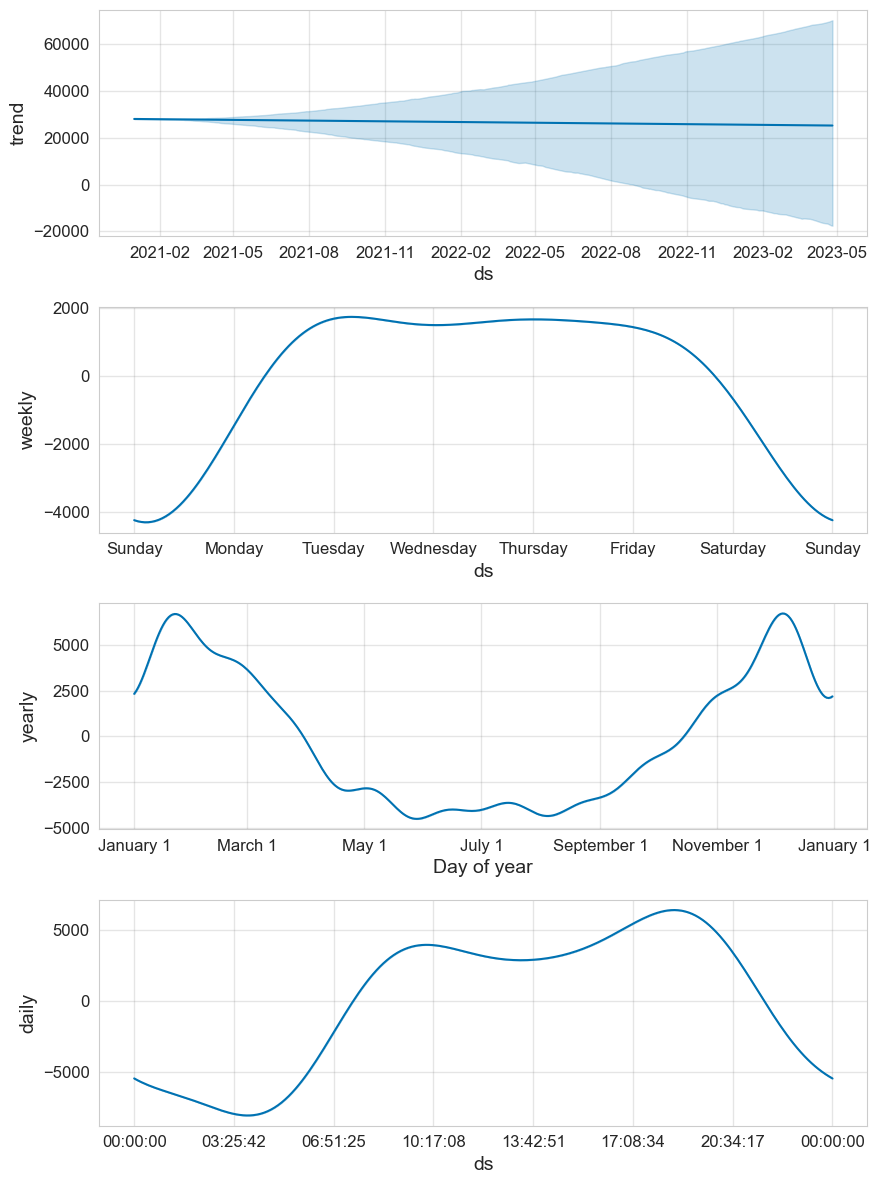

In [12]:
prophet_model.plot_components(prophet_predict_df);

We can now plot the prediction on the test set:

In [13]:
## this is necessary to plot the model, since I have a older version of prophet

from __future__ import absolute_import, division, print_function

import logging

import numpy as np
import pandas as pd

from fbprophet.diagnostics import performance_metrics

logger = logging.getLogger('prophet.plot')



try:
    from matplotlib import pyplot as plt
    from matplotlib.dates import (
        MonthLocator,
        num2date,
        AutoDateLocator,
        AutoDateFormatter,
    )
    from matplotlib.ticker import FuncFormatter

    from pandas.plotting import deregister_matplotlib_converters
    deregister_matplotlib_converters()
except ImportError:
    logger.error('Importing matplotlib failed. Plotting will not work.')

try:
    import plotly.graph_objs as go
    from plotly.subplots import make_subplots
except ImportError:
    logger.error('Importing plotly failed. Interactive plots will not work.')

def prophet_plot(
    m, fcst, ax=None, uncertainty=True, plot_cap=True, xlabel='ds', ylabel='y',
    figsize=(10, 6), include_legend=False
):
    """Plot the Prophet forecast.

    Parameters
    ----------
    m: Prophet model.
    fcst: pd.DataFrame output of m.predict.
    ax: Optional matplotlib axes on which to plot.
    uncertainty: Optional boolean to plot uncertainty intervals, which will
        only be done if m.uncertainty_samples > 0.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    xlabel: Optional label name on X-axis
    ylabel: Optional label name on Y-axis
    figsize: Optional tuple width, height in inches.
    include_legend: Optional boolean to add legend to the plot.

    Returns
    -------
    A matplotlib figure.
    """
    if ax is None:
        fig = plt.figure(facecolor='w', figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
    fcst_t = fcst['ds'].dt.to_pydatetime()
    ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
            label='Observed data points')
    ax.plot(fcst_t, fcst['yhat'], ls='-', c='#0072B2', label='Forecast')
    if 'cap' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['cap'], ls='--', c='k', label='Maximum capacity')
    if m.logistic_floor and 'floor' in fcst and plot_cap:
        ax.plot(fcst_t, fcst['floor'], ls='--', c='k', label='Minimum capacity')
    if uncertainty and m.uncertainty_samples:
        ax.fill_between(fcst_t, fcst['yhat_lower'], fcst['yhat_upper'],
                        color='#0072B2', alpha=0.2, label='Uncertainty interval')
    # Specify formatting to workaround matplotlib issue #12925
    locator = AutoDateLocator(interval_multiples=False)
    formatter = AutoDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if include_legend:
        ax.legend()
    fig.tight_layout()
    return fig

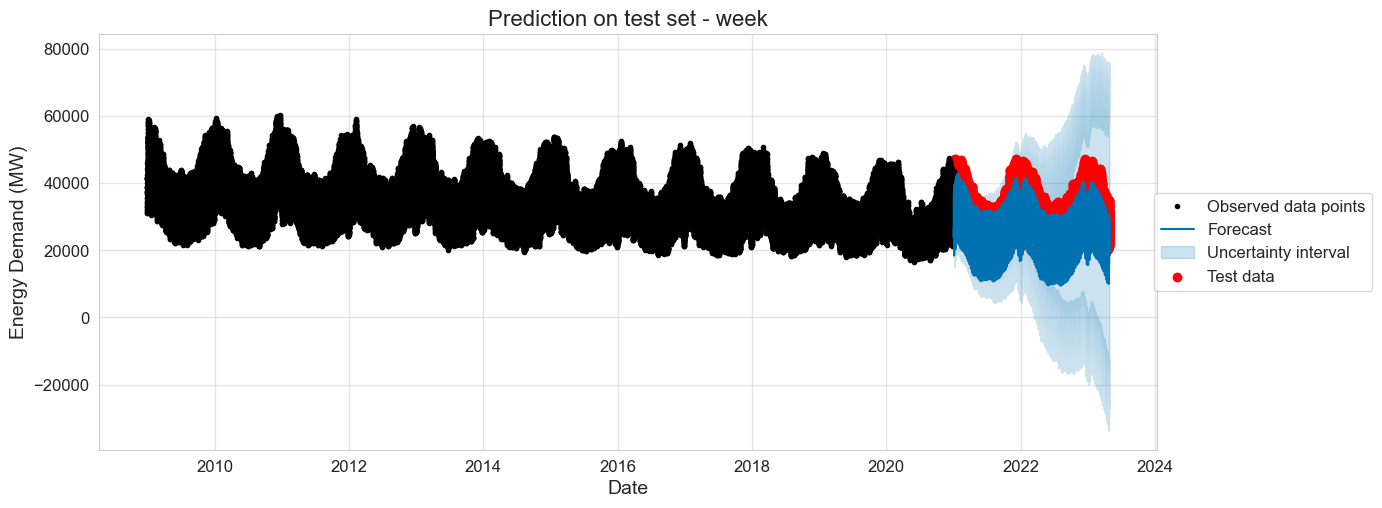

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))

prophet_plot(m=prophet_model, fcst=prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(test_data_prophet['ds'], test_data_prophet['y'], color='r', label="Test data")
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1)

ax.set_title("Prediction on test set - week")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

Similarly to the analysis I performed on the prediction results using XGBoost, one can focus on a single week to check how the individual predictions compare with the true data.

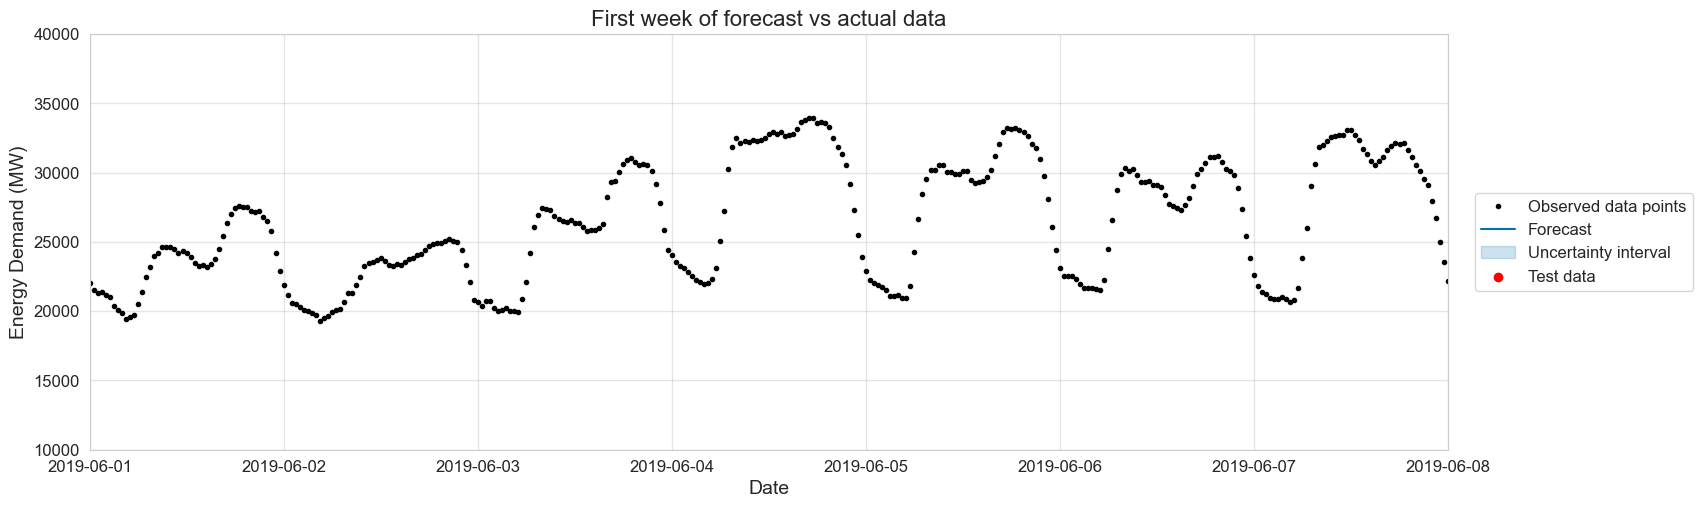

In [15]:
fig, ax = plt.subplots(figsize=(15,5))

prophet_plot(m=prophet_model, fcst=prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(test_data_prophet['ds'], test_data_prophet['y'], color='r', label="Test data")
ax.set_xbound(lower=datetime.date(2021,6,1), upper=datetime.date(2021,6,8))
ax.set_ylim(bottom=10000, top=40000)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("First week of forecast vs actual data")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

The above graph belongs to the first week of the test set. It does a fairly good job, but more importantly, it includes the confidence intervals. 

As we saw in the overall prediction comparison, the confidence intervals widen as time goes on. Let's have a look at what the comparison looks like some months after the beginning of the test set:

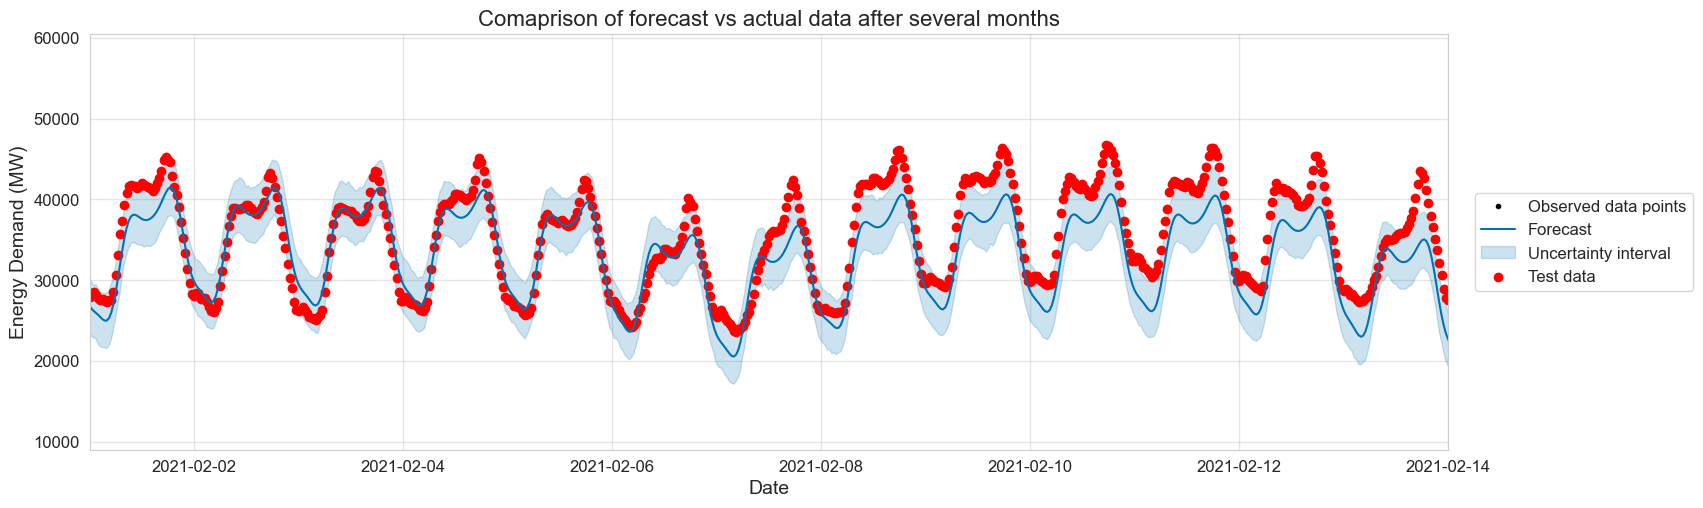

In [16]:
fig, ax = plt.subplots(figsize=(15,5))

prophet_plot(m=prophet_model, fcst=prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(test_data_prophet['ds'], test_data_prophet['y'], color='r', label="Test data")
ax.set_xbound(lower=datetime.date(2023,2,1), upper=datetime.date(2023,2,14))
ax.set_ylim(9000, 60500)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("Comaprison of forecast vs actual data after several months")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

We can now see more clearly how the confidence interval widens.

Finally, let's have a look at the MAPE value:

In [17]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape
from sklearn.metrics import mean_squared_error

In [18]:
%%time
mape_prophet_simple = mean_absolute_percentage_error(
    test_data_prophet['y'], prophet_predict_df["yhat"]
)
rmse_prophet_simple = np.sqrt(mean_squared_error(test_data_prophet['y'], prophet_predict_df["yhat"]))
print(
    "Mean Absolute Percentage Error of the simple Prophet model is: %.2f"
    % mape_prophet_simple
)
print(
    "Root Mean Squared Error of the simple Prophet models is: %.2f MW" % rmse_prophet_simple
)

Mean Absolute Percentage Error of the simple Prophet model is: 11.87
Root Mean Squared Error of the simple Prophet models is: 4201.83 MW
Wall time: 2.36 ms


## Prophet with holidays

One of Prophet's strong suits is the ability to include holidays in the prediction. This is particularly useful to me as I have already gathered information about the bank holidays in the UK. [Prophet's API](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#modeling-holidays-and-special-events) includes a section describing how to implement it. Basically, one needs to create a dataframe containing the days and the name of the holiday, with the columns named `ds` and `holiday`.

In [8]:
import holidays
bank_holiday_england = holidays.UK(subdiv="England", years=range(2009, 2024), observed=True).items()

In [9]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

In [10]:
holiday_df = pd.DataFrame(data={"ds": holiday_dates_observed, "holiday": holiday_names_observed})
holiday_df.head()

ds              holiday
0 2009-01-01       New Year's Day
1 2009-04-10          Good Friday
2 2009-04-13        Easter Monday
3 2009-05-04              May Day
4 2009-05-25  Spring Bank Holiday

In [22]:
%%time
prophet_hol_model = Prophet(holidays=holiday_df)
prophet_hol_model.fit(train_data_prophet)

Wall time: 23min 14s


In [23]:
# save the model
joblib.dump(prophet_hol_model, project_path.joinpath('data/models/prophet_hol_model.pkl'))

['C:\\Users\\mpena\\OneDrive\\Escritorio\\TFG\\PYTHON\\data\\models\\prophet_hol_model.pkl']

In [24]:
# load the model
prophet_hol_model = joblib.load(project_path.joinpath('data/models/prophet_hol_model.pkl')) # Carga del modelo.

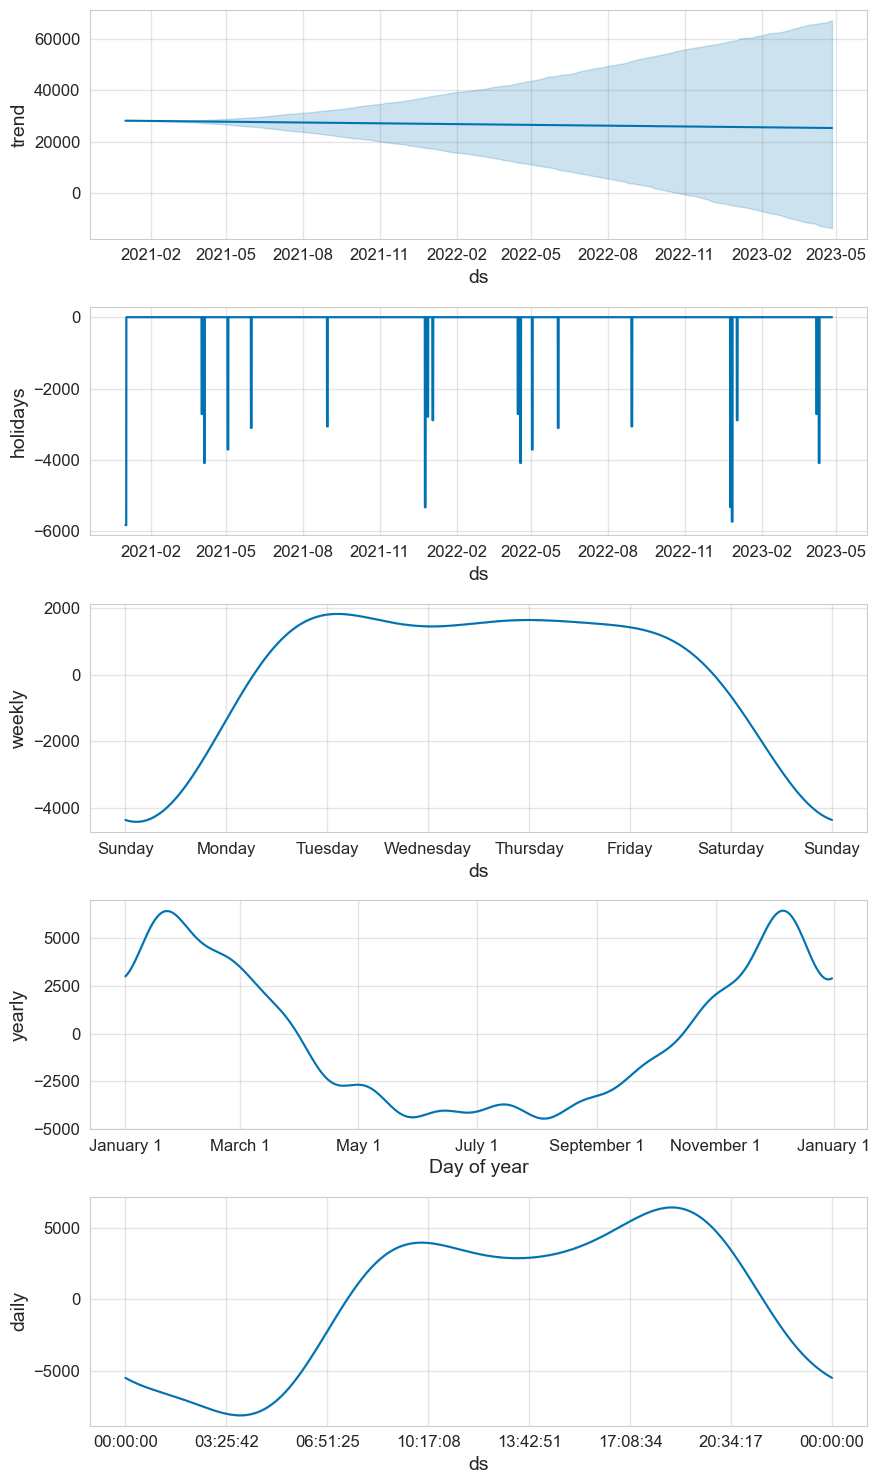

In [28]:
prophet_hol_predict_df = prophet_hol_model.predict(test_data_prophet)
prophet_hol_model.plot_components(prophet_hol_predict_df);

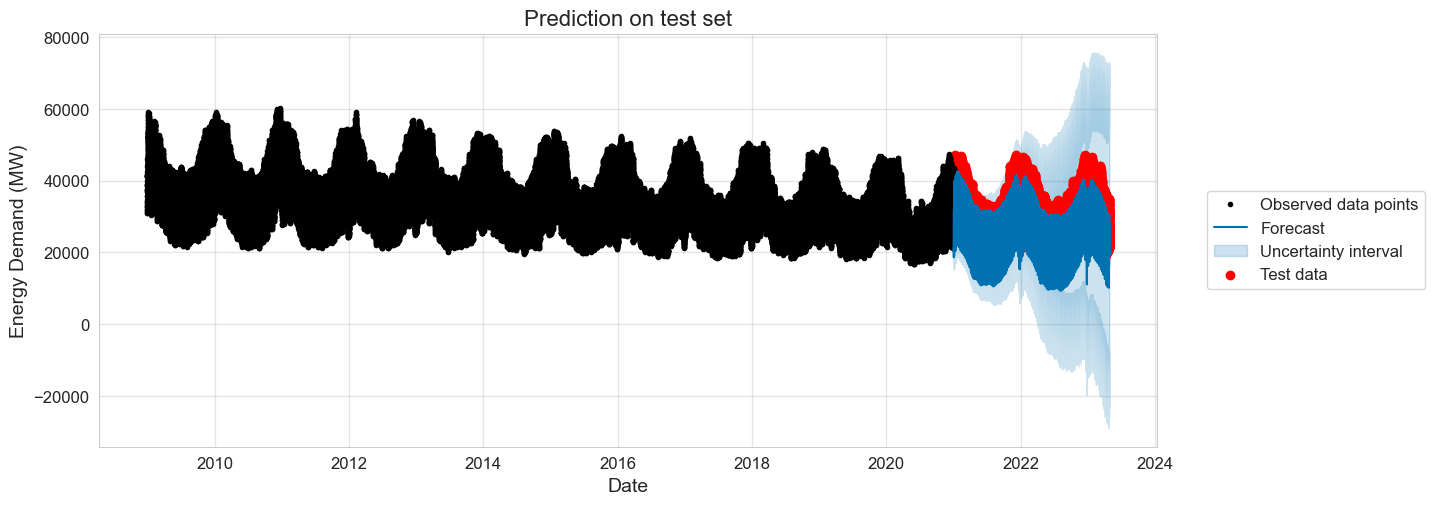

In [29]:
fig, ax = plt.subplots(figsize=(12, 5))

prophet_plot(m=prophet_hol_model, fcst=prophet_hol_predict_df, ax=ax, include_legend=True)
ax.scatter(test_data_prophet['ds'], test_data_prophet['y'], color='r', label="Test data")
ax.legend(bbox_to_anchor=(1.15, 0.5), loc="center", ncol=1)

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

The prediction on the test set seems to be very similar to the previous Prophet model. This is the expected behaviour as the new model parameter should only affect the holidays. Therefore, let's focus on a period with multiple holidays, such as the period between December 23rd and December 28th (two bank holidays), and compare the two Prophet models:

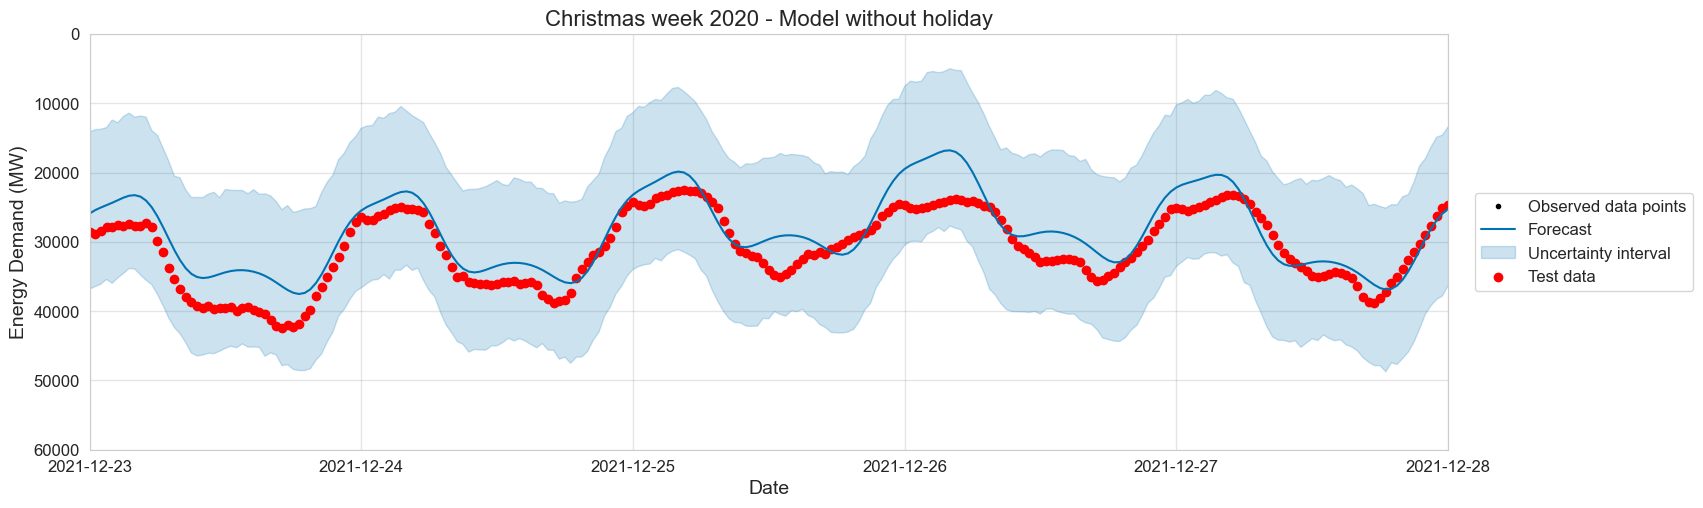

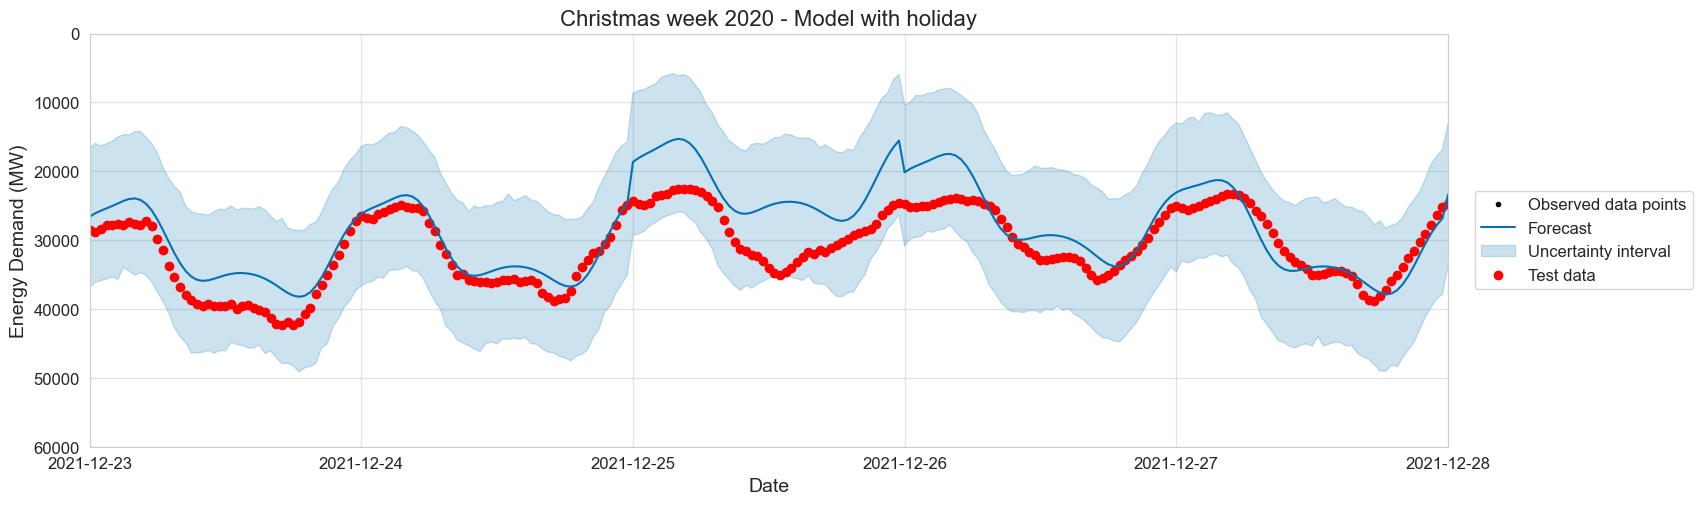

In [50]:
fig, ax = plt.subplots(figsize=(15,5))

prophet_plot(m=prophet_model, fcst=prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(test_data_prophet['ds'], test_data_prophet['y'], color='r', label="Test data")
ax.set_xlim(left=datetime.date(2021,12,23), right=datetime.date(2021,12,28))
ax.set_ylim(bottom=60000, top=0)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("Christmas week 2020 - Model without holiday")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");


fig, ax = plt.subplots(figsize=(15,5))

prophet_plot(m=prophet_hol_model, fcst=prophet_hol_predict_df, ax=ax, include_legend=True)
ax.scatter(test_data_prophet['ds'], test_data_prophet['y'], color='r', label="Test data")
ax.set_xlim(left=datetime.date(2021,12,23), right=datetime.date(2021,12,28))
ax.set_ylim(bottom=60000, top=0)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("Christmas week 2020 - Model with holiday")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

The prediction is way more accurate for the second model, proving that this functionality works, especially when many holidays are fed to the model and it can learn the pattern on those days. 

It's interesting that right before and right after the holiday there's a steep change (either upwards or downwards) in the value to adjust the value to "non-holiday". The model could be improved if it picked up the trend more slowly. 

In [31]:
mape_prophet_holiday = mean_absolute_percentage_error(
    test_data_prophet['y'], prophet_hol_predict_df["yhat"]
)
rmse_prophet_holiday = np.sqrt(mean_squared_error(test_data_prophet['y'], prophet_hol_predict_df["yhat"]))
print(
    "Mean Absolute Percentage Error of the holiday Prophet model is: %.2f"
    % mape_prophet_holiday
)
print(
    "Root Mean Squared Error of the Prophet (with holiday) model is: %.2f MW" % rmse_prophet_holiday
)

Mean Absolute Percentage Error of the holiday Prophet model is: 11.88
Root Mean Squared Error of the Prophet (with holiday) model is: 4204.48 MW


## Prophet with cross-validation and "grid search"

Similarly to implementing cross-validation and grid search with XGBoost, I want to use these techniques together with Prophet to generate better predictions. [Prophet's API](https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation) includes a section that covers this. Unfortunately, I didn't manage to use the cross validation class because it took too long to run. In case you're interested in that class, the API's example is as follows:

`from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')`

It's worth noting that the model needs to be fitted first and the `cross_validation` object can be used to compute the metrics from each fold.

Also, since each model takes long to be fitted (up to 2 miniutes), I chose only 2 splits, which isn't a recommended practice, especially given that this is a large dataset,  


In [32]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [33]:
df = pd.read_csv('../data/01_raw/historic_demand_2009_2023.csv')
df.columns = df.columns.str.lower()
df.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)
df.drop(columns=["nsl_flow", "eleclink_flow"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

# Move the new column
column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)
df["settlement_date"] = pd.to_datetime(
    (df["settlement_date"] + " " + df["period_hour"])
)

df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

df

unnamed: 0 period_hour  settlement_period     nd    tsd  \
settlement_date                                                                
2009-01-01 00:00:00           0     0:00:00                  1  37910  38704   
2009-01-01 00:30:00           1     0:30:00                  2  38047  38964   
2009-01-01 01:00:00           2     1:00:00                  3  37380  38651   
2009-01-01 01:30:00           3     1:30:00                  4  36426  37775   
2009-01-01 02:00:00           4     2:00:00                  5  35687  37298   
...                         ...         ...                ...    ...    ...   
2023-04-25 21:30:00      250937    21:30:00                 44  30635  31142   
2023-04-25 22:00:00      250938    22:00:00                 45  28784  29292   
2023-04-25 22:30:00      250939    22:30:00                 46  27302  27807   
2023-04-25 23:00:00      250940    23:00:00                 47  25457  26244   
2023-04-25 23:30:00      250941    23:30:00                 48  24371  25407   

                     england_wales_demand  embedded_wind_generation  \
settlement_date                                                       
2009-01-01 00:00:00                 33939                        54   
2009-01-01 00:30:00                 34072                        53   
2009-01-01 01:00:00                 33615                        53   
2009-01-01 01:30:00                 32526                        50   
2009-01-01 02:00:00                 31877                        50   
...                                   ...                       ...   
2023-04-25 21:30:00                 27695                       490   
2023-04-25 22:00:00                 26071                       489   
2023-04-25 22:30:00                 24719                       487   
2023-04-25 23:00:00                 23014                       492   
2023-04-25 23:30:00                 21983                       497   

                     embedded_wind_capacity  embedded_solar_generation  \
settlement_date                                                          
2009-01-01 00:00:00                    1403                          0   
2009-01-01 00:30:00                    1403                          0   
2009-01-01 01:00:00                    1403                          0   
2009-01-01 01:30:00                    1403                          0   
2009-01-01 02:00:00                    1403                          0   
...                                     ...                        ...   
2023-04-25 21:30:00                    6545                          0   
2023-04-25 22:00:00                    6545                          0   
2023-04-25 22:30:00                    6545                          0   
2023-04-25 23:00:00                    6545                          0   
2023-04-25 23:30:00                    6545                          0   

                     embedded_solar_capacity  non_bm_stor  \
settlement_date                                             
2009-01-01 00:00:00                        0            0   
2009-01-01 00:30:00                        0            0   
2009-01-01 01:00:00                        0            0   
2009-01-01 01:30:00                        0            0   
2009-01-01 02:00:00                        0            0   
...                                      ...          ...   
2023-04-25 21:30:00                    13080            0   
2023-04-25 22:00:00                    13080            0   
2023-04-25 22:30:00                    13080            0   
2023-04-25 23:00:00                    13080            0   
2023-04-25 23:30:00                    13080            0   

                     pump_storage_pumping  ifa_flow  ifa2_flow  britned_flow  \
settlement_date                                                                
2009-01-01 00:00:00                    33      2002          0             0   
2009-01-01 00:30:00                   157      2002        

In [34]:
df = pd.read_parquet('../data/02_intermediate/data.parquet')

threshold_date_1 = "06-01-2019"
threshold_date_2 = "06-01-2021"
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

# Prepare the training, testing and hold-out data
y_train = train_data['tsd']
y_test = test_data['tsd']
y_hold_out = hold_out_data['tsd']
y_all = df['tsd']

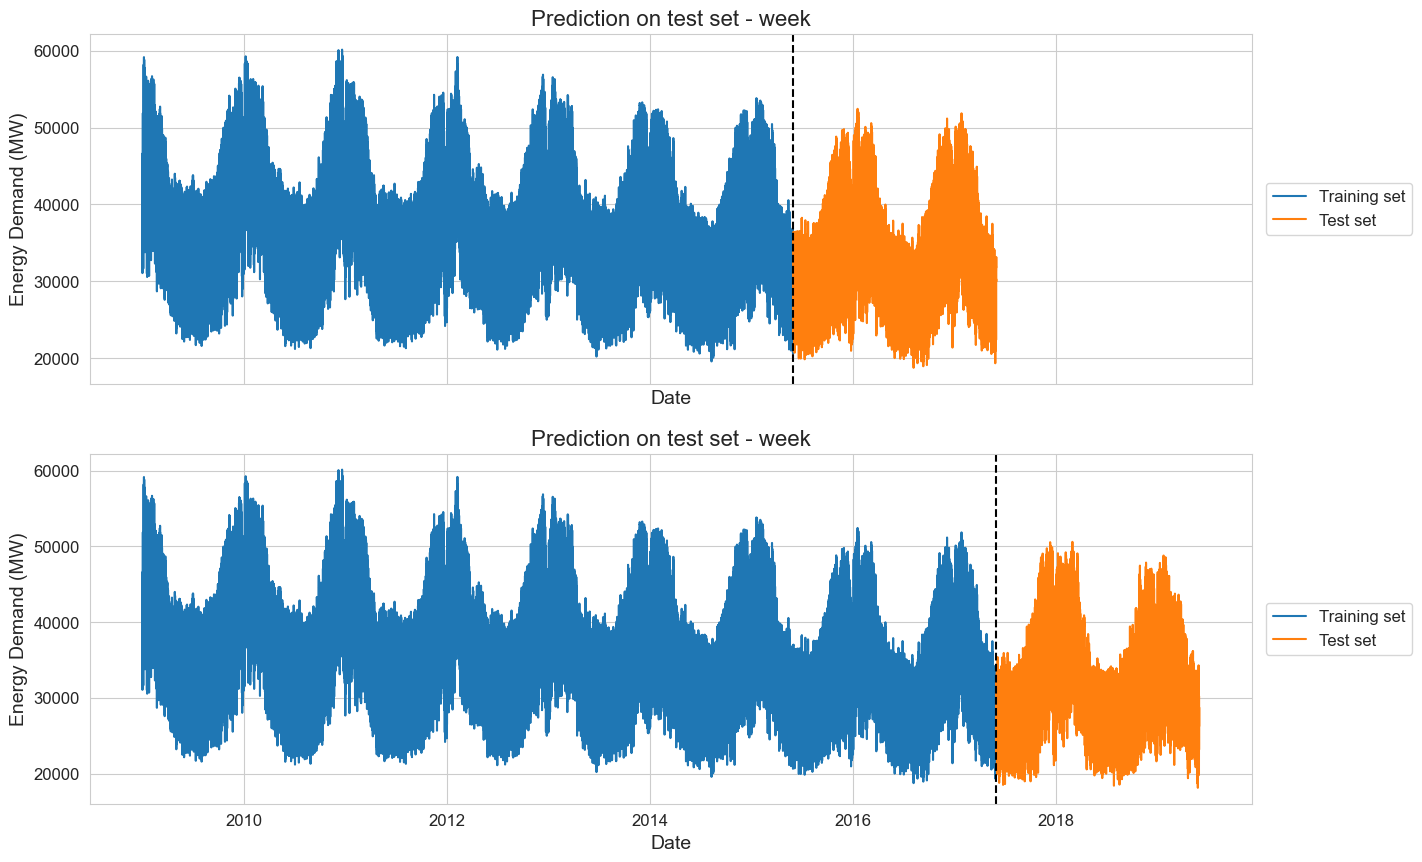

In [35]:
n_years_test = 2
tss_prophet = TimeSeriesSplit(n_splits=2, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

fold = 0
for train_index, test_index in tss_prophet.split(df[df.index<threshold_date_1]):
    train_data = y_train.to_frame() \
                        .reset_index() \
                        .iloc[train_index] \
                        .rename(columns={"settlement_date": "ds", "tsd": "y"})

    test_data = y_train.to_frame() \
                    .reset_index() \
                    .iloc[test_index] \
                    .rename(columns={"settlement_date": "ds", "tsd": "y"})
    
    axes[fold].plot(train_data["ds"], train_data["y"], label="Training set")
    axes[fold].plot(test_data["ds"], test_data["y"], label="Test set")
    axes[fold].axvline(test_data["ds"].min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1

In [36]:
%%time

# Define the parameter grid for the Prophet model
param_grid = {"changepoint_prior_scale": [0.05], "seasonality_prior_scale": [2.5, 10]}

# Create all possible combinations of the parameter grid
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

rmse_cv_gs = []

for params in all_params:
    rmse_cv = []
    
    for train_index, test_index in tss_prophet.split(df[df.index<threshold_date_1]):
        train_data = y_train.to_frame() \
                            .reset_index() \
                            .iloc[train_index] \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})

        test_data = y_train.to_frame() \
                            .reset_index() \
                            .iloc[test_index] \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})

        model = Prophet(**params, holidays=holiday_df)
        model.fit(train_data)

        prediction = model.predict(test_data)
        mse_val = mean_squared_error(test_data["y"], prediction["yhat"])
        rmse_cv.append(np.sqrt(mse_val))
    
    rmse_cv_gs.append(np.mean(rmse_cv))
    
grid_search_results = pd.DataFrame(all_params)
grid_search_results['rmse'] = rmse_cv_gs

grid_search_results

Wall time: 1h 56min 56s


changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.05                      2.5  2927.673645
1                     0.05                     10.0  2922.044670

In this example, there are only two hyperparameter combinations and it's fairly straightforward to identifty the 

In [37]:
best_params = all_params[np.argmin(rmse_cv_gs)]
print(best_params)

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10}


In [6]:
best_params = {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10}

In [ ]:
%%time
# Create Prophet using the best parameters from the grid search
prophet_best = Prophet(**best_params, holidays=holiday_df)
prophet_best.fit(train_data_prophet)

prophet_best_predict_df = prophet_best.predict(test_data_prophet)

In [51]:
# save the model
joblib.dump(prophet_best, project_path.joinpath('data/models/prophet_best.pkl'))

['C:\\Users\\mpena\\OneDrive\\Escritorio\\TFG\\PYTHON\\data\\models\\prophet_best.pkl']

In [24]:
# load the model
prophet_best = joblib.load(project_path.joinpath('data/models/prophet_best.pkl')) # Carga del modelo.

In [45]:
# Compute MAPE value
mape_prophet_cv_gs = mean_absolute_percentage_error(
    test_data_prophet['y'], prophet_best_predict_df["yhat"]
)
rmse_prophet_cv_gs = np.sqrt(
    mean_squared_error(test_data_prophet['y'], prophet_best_predict_df["yhat"])
)
print(
    "Mean Absolute Percentage Error of the best-parameters Prophet model is: %.2f"
    % mape_prophet_cv_gs
)
print(
    "Root Mean Squared Error of the Prophet (with cross-validation) model is: %.2f MW" % rmse_prophet_cv_gs
)

Mean Absolute Percentage Error of the best-parameters Prophet model is: 11.88
Root Mean Squared Error of the Prophet (with cross-validation) model is: 4204.48 MW


## Prediction into the future

Once the best set of parameters has been found, we can use that model into the future. To get the most of our model, we will first fit the entire dataset and then make the future predictions.

Prophet includes its own function to create a dataframe that goes into the future, `model.make_future_model()`, which makes things even easier. 

In [14]:
%%time
# Fit a new model using all the data as training data
prophet_future_model = Prophet(**best_params, holidays=holiday_df)
prophet_future_model.fit(all_data_prophet)

Wall time: 20min 42s


In [15]:
# Make predictions on future dataframe
prophet_future = prophet_future_model.make_future_dataframe(periods=210*24, freq="H", include_history=False)
prophet_fut_forecast = prophet_future_model.predict(prophet_future)

In [16]:
# save the model
joblib.dump(prophet_future_model, project_path.joinpath('data/models/prophet_future_model.pkl'))

['C:\\Users\\mpena\\OneDrive\\Escritorio\\TFG\\PYTHON\\data\\models\\prophet_future_model.pkl']

In [17]:
# load the model
prophet_future_model = joblib.load(project_path.joinpath('data/models/prophet_future_model.pkl')) # Carga del modelo.

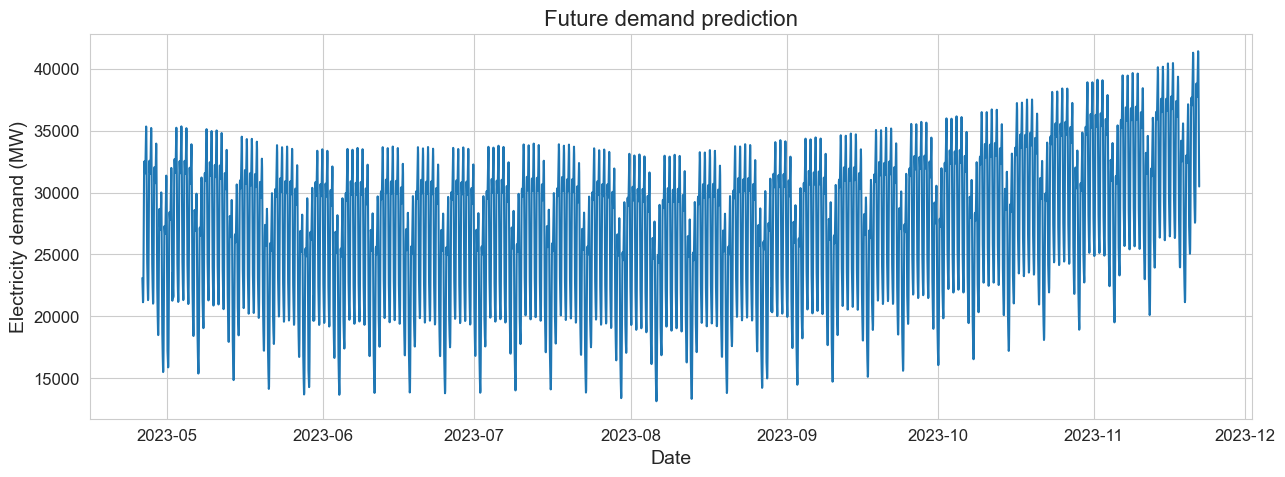

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(prophet_fut_forecast["ds"], prophet_fut_forecast["yhat"])

ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Future demand prediction");

Finally, one can compare the future predictions from the different models since both models span for the same number of days.